# Simple Reinforcement Learning

In [1]:
import numpy as np
import gym
import gym_snake
import random
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# Create Gym Environment

In [2]:
env = gym.make('snake-v0')

In [5]:
env.action_space.n

4

## Gym object

In [2]:
env = gym.make('FrozenLake-v0')

## Q-table

In [3]:
action_space_size = env.action_space.n
state_space_size = env.observation_space.n

q_table = np.zeros((state_space_size, action_space_size))

## Initial Parameters

In [21]:
num_episodes = 10000
max_steps_per_episode = 100

learning_rate = 0.1
discount_rate = 0.99

exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.001

# Sample Algorithm

In [22]:
rewards_all_episodes = []

# Q-learning algo
for episode in tqdm(range(num_episodes)):
    state = env.reset()
    
    done = False
    rewards_current_episode = 0
    
    for step in range(max_steps_per_episode):
        
        # Exploration-Exploitation Trade Off
        exploration_rate_threshold = random.uniform(0,1)
        if exploration_rate_threshold > exploration_rate:
            action = np.argmax(q_table[state,:])
        else:
            action = env.action_space.sample()
            
        new_state, reward, done, info = env.step(action)
        
        # Update Q Table for Q(s,a)
        q_table[state,action] = q_table[state,action] * (1-learning_rate) + \
            learning_rate * (reward+discount_rate*np.max(q_table[new_state,:]))
        
        state = new_state
        rewards_current_episode += reward
        
        if done == True:
            break
    
    # Exploratione rate decay
    exploration_rate = min_exploration_rate + (max_exploration_rate - min_exploration_rate) \
    * np.exp(-exploration_decay_rate*episode)
    
    rewards_all_episodes.append(rewards_current_episode)

In [23]:
# Calculate and print average reward per thousand episodes
rewards_per_thousand_episodes = np.split(np.array(rewards_all_episodes), num_episodes/1000)
count = 1000
print('rewards per thousand episodes')
for r in rewards_per_thousand_episodes:
    print(f'{count}: {str(sum(r/1000))}')
    count += 1000
    
print('Final Q-table')
print(q_table)

rewards per thousand episodes
1000: 0.04000000000000003
2000: 0.21300000000000016
3000: 0.43600000000000033
4000: 0.5410000000000004
5000: 0.6060000000000004
6000: 0.6890000000000005
7000: 0.7040000000000005
8000: 0.6910000000000005
9000: 0.6860000000000005
10000: 0.6480000000000005
Final Q-table
[[0.55778367 0.48986979 0.4859772  0.49323249]
 [0.28348042 0.32444763 0.31458259 0.49983388]
 [0.37646971 0.39708697 0.40069852 0.4537027 ]
 [0.35179921 0.17399257 0.32692037 0.43464801]
 [0.58415981 0.4200325  0.32309746 0.26199295]
 [0.         0.         0.         0.        ]
 [0.15277294 0.09229234 0.29997181 0.13361685]
 [0.         0.         0.         0.        ]
 [0.51511563 0.47625748 0.28602025 0.64684162]
 [0.52509826 0.70066564 0.45383475 0.40807566]
 [0.70472963 0.31779629 0.2366279  0.30745818]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.51173357 0.51655776 0.78379804 0.41480782]
 [0.69259046 0.90767795 0.75580006 0.7197855

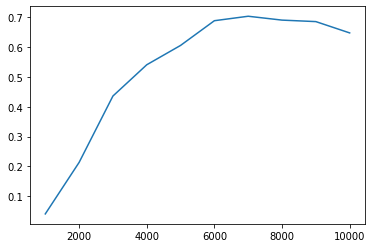

In [24]:
count = 1000
rews, counts = [], []
for r in rewards_per_thousand_episodes:
    counts.append(count)
    rews.append(sum(r/1000))
    count += 1000
plt.plot(counts, rews)

In [25]:
np.max(rews)

0.7040000000000005

# Deep Q-Learning

In [18]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
# from tqdm.autonotebook import tqdm

## Setup display

In [19]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

## Deep Q-Network Class

In [20]:
class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=24)
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)
        
    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

## Experience Class

In [21]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

In [22]:
e = Experience(2,3,1,4)
e

Experience(state=2, action=3, next_state=1, reward=4)

## Replay Memory Class

In [23]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

## Epsilon Greedy Strategy

In [24]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)

## Reinforcement Learning Agent

In [25]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
    
    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        
        if rate > random.random():
            action = random.randrange(self.num_actions) # explore
            return torch.tensor([action]).to(device)
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(device) # exploit

## Environment Manager

In [26]:
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
        
    def reset(self):
        self.env.reset()
        self.current_screen = None
    
    def close(self):
        self.env.close()
        
    def render(self, mode='human'):
        return self.env.render(mode)
    
    def num_actions_available(self):
        return self.env.action_space.n

    def take_action(self, action):
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    
    def just_starting(self):
        return self.current_screen is None
    
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
        
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
        
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2,0,1)) 
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        
        #Strip off top and bottom
        top = int(screen_height*0.4)
        bottom = int(screen_height*0.8)
        screen = screen[:, top:bottom, :]
        return screen
    
    def transform_screen_data(self, screen):
        # convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        
        # use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage(),
            T.Resize((40,90)),
            T.ToTensor()
        ])
        
        return resize(screen).unsqueeze(0).to(self.device) # add a battch dimension

In [28]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# em = CartPoleEnvManager(device)
# em.reset()
# screen = em.render('rgb_array')

# plt.figure()
# plt.imshow(screen)
# plt.title('Non-Processed Screen Sample')
# plt.show()

In [29]:
# screen = em.get_processed_screen()
# plt.figure()
# plt.imshow(screen.squeeze(0).permute(1,2,0), interpolation='none')
# plt.title('Processed Screen Example')
# plt.show()

## Sample Starting State

In [31]:
# screen = em.get_state()

# plt.figure()
# plt.imshow(screen.squeeze(0).permute(1,2,0), interpolation='none')
# plt.title('Processed Screen Sample')
# plt.show()

## Plotting Function

In [32]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    plt.plot(get_moving_average(moving_avg_period, values))
    plt.pause(0.001)
    if is_ipython: display.clear_output(wait=True)
        
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

## Tensor Preprocessing

In [33]:
def extract_tensors(experiences):
    batch = Experience(*zip(*experiences))
    
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)
    
    return (t1,t2,t3,t4)

## QValue Calculator

In [34]:
class QValues():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # static methods can be called without creating an instance of the class
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod
    def get_next(target_net, next_states):
        final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

# Main Program

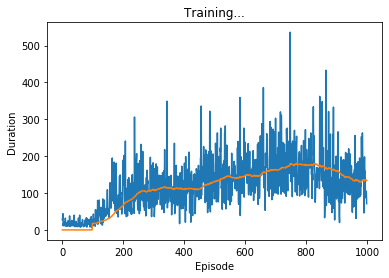

In [35]:
# hyperparameters
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 1000

# define classes
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

# torch nn networks
policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() # not in training mode
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

# run episodes
episode_durations = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    
    # main loop
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values*gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break
            
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()